In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import os 
import cv2
import torch
from facenet_pytorch import InceptionResnetV1
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from torchvision import transforms


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/face_regconition/face_image'

In [ ]:
files = os.listdir(path)


In [ ]:
files

['ta_1.jpg',
 'ta_2.jpg',
 'ta_3.jpg',
 'khanh_1.jpg',
 'hung_1.jpg',
 'phong_1.jpg',
 'hung_2.jpg',
 'hung_3.jpg',
 'hung_4.jpg',
 'hung_5.jpg',
 'hung_6.jpg',
 'hung_7.jpg',
 'khanh_3.jpg',
 'khanh_2.jpg',
 'phong_2.jpg',
 'khanh_4.jpg',
 'hung_8.jpg',
 'phong_3.jpg']

In [ ]:
# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
facenet_model = InceptionResnetV1(pretrained='vggface2').eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

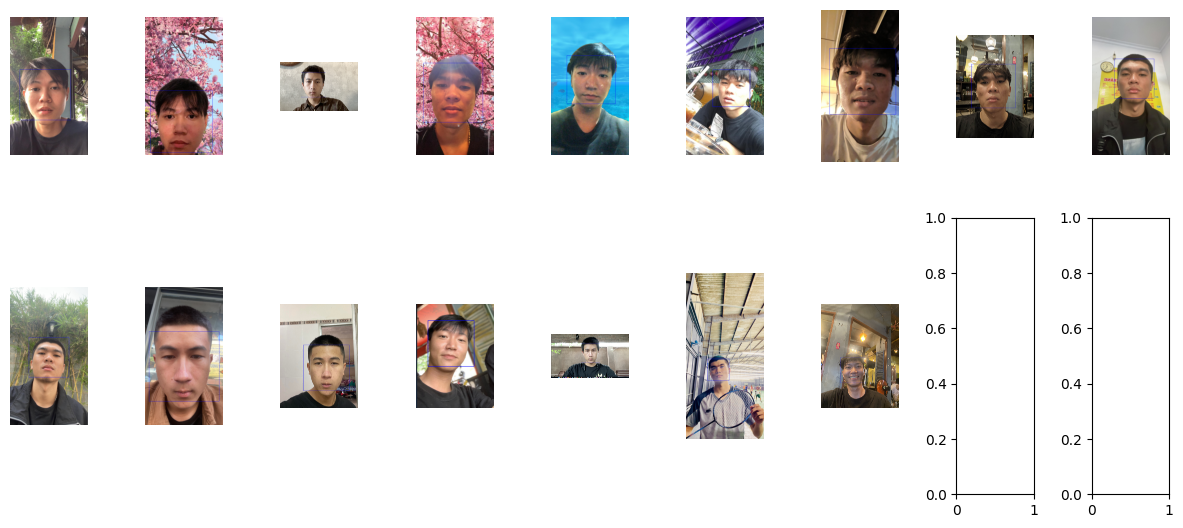

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Create a grid of subplots
num_faces = len(files)
num_rows = 2  # Number of rows in the grid
num_cols = num_faces // num_rows  # Number of columns in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

i = 0
j = 0

# Loop through the files
for file in files:
    image = cv2.imread('/content/drive/My Drive/face_regconition/face_image/' + file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.12, minNeighbors=6, minSize=(200, 200))
    
    # Draw rectangles around the detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2) # Change color to blue (BGR format)
        axes[i][j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i][j].axis('off')  # Hide axis labels
        axes[i][j].grid(False)  # Hide grid lines
        j += 1
        if j == num_cols:
            j = 0
            i = 1

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
normalize = transforms.Compose([
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [ ]:
known_embeddings = {}
for file in files:
    image = cv2.imread('/content/drive/My Drive/face_regconition/face_image/' + file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.12, minNeighbors=6, minSize=(200, 200))

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face = cv2.resize(face, (160, 160))  # Resize face to match input size of the model
        face = torch.from_numpy(face).permute(2, 0, 1).unsqueeze(0).float()  # Convert face to torch tensor
        face = face / 255.0
        face = normalize(face)
                # Extract face embeddings using Facenet model
        with torch.no_grad():
            emb = facenet_model(face)   
        known_embeddings[file] = emb 

In [ ]:
# Save the dictionary to a file using pickle
with open('/content/drive/My Drive/face_regconition/face_embeddings.pkl', 'wb') as f:
    pickle.dump(known_embeddings, f)
    


In [ ]:
with open('/content/drive/My Drive/face_regconition/face_embeddings.pkl', 'rb') as f:
    known_embeddings = pickle.load(f)

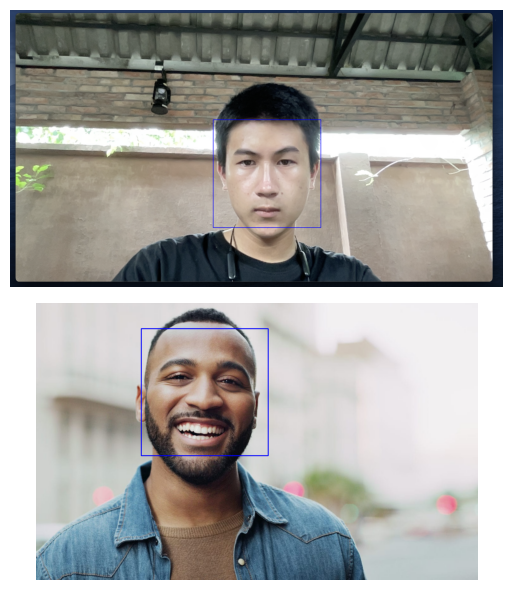

In [ ]:
path = '/content/drive/My Drive/face_regconition/face_image_test/'
files = os.listdir(path)
# Create a grid of subplots
num_faces = len(files)
fig2, axes2 = plt.subplots(num_faces, figsize=(12, 6))
j = 0
# Loop through the files
for file in files:
    image = cv2.imread('/content/drive/My Drive/face_regconition/face_image_test/' + file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.12, minNeighbors=6, minSize=(200, 200))
    
    # Draw rectangles around the detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2) # Change color to blue (BGR format)
        axes2[j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes2[j].axis('off')  # Hide axis labels
        axes2[j].grid(False)  # Hide grid lines
    j+=1

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
similarity_threshold = torch.tensor(0.80)
image = cv2.imread('/content/drive/My Drive/face_regconition/face_image_test/khanh.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200))
# Loop through the detected faces
for (x, y, w, h) in faces:
    # Extract the face region
    face = image[y:y+h, x:x+w]
    # Convert the face to RGB and resize it
    face = cv2.resize(face, (160, 160))  # Resize face to match input size of the model
    face = torch.from_numpy(face).permute(2, 0, 1).unsqueeze(0).float()  # Convert face to torch tensor
    face = face / 255.0
    face = normalize(face)

    # Extract face embeddings using Facenet model
    with torch.no_grad():
        emb = facenet_model(face)   
    similarity_scores = torch.cosine_similarity(emb, torch.stack(list(known_embeddings.values())).squeeze(), dim=1)
    print(similarity_scores)
    max_values, id = similarity_scores.max(dim=0)
    comparison = max_values > similarity_threshold
    if comparison:
        recognized = True
        face_id = list(known_embeddings.keys())[id]
    else:
        recognized = False
        face_id = None

tensor([ 0.6286, -0.0105,  0.8035,  0.1471,  0.6967,  0.4602,  0.1715,  0.2170,
         0.3238,  0.5041,  0.6909,  0.7251,  0.5016,  0.9745,  0.2660,  0.6264])


In [ ]:
print(face_id)

khanh_4.jpg
